<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2012%3A%20CRM%20%26%20Marketing%20Analytics/12_2_Revenue_Management_and_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CRM & Marketing Analytics**
## Revenue Management and Pricing

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Import Data
url="https://docs.google.com/spreadsheets/d/1pIqxchx7m0kJXlm0OmnqhAWeFfSRxj2B/edit?usp=sharing&ouid=116301364204212013828&rtpof=true&sd=true"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_excel(path)
data.head()


,Unnamed: 0,Year,Month,RecommendedPrice,AvgSalesPrice,TotalSold,SoldWithoutDiscount,Discount,Promotion,Competitor_Price,PreviousAvgSalesPrice,PreviousTotalSold,TwoPreviousAvgSalesPrice,TwoPreviousTotalSold,PreviousCompetitor_Price,TwoPreviousCompetitor_Price,DiscountedPrice,Euro
0,2,2019,3,279,269.426000,6782,6782,0,0,545.0,268.422479,4585,269.979652,3510,545.0,545.0,279,6.0876
1,3,2019,4,359,287.498163,4946,4946,0,1,554.0,269.426000,6782,268.422479,4585,545.0,545.0,359,6.2299
2,4,2019,5,359,292.788821,7449,7449,0,1,554.0,287.498163,4946,269.426000,6782,554.0,545.0,359,6.6890
3,5,2019,6,399,317.292266,4614,4614,0,1,554.0,292.788821,7449,287.498163,4946,554.0,554.0,399,6.5265
4,6,2019,7,399,357.696890,3402,3402,0,0,620.0,317.292266,4614,292.788821,7449,554.0,554.0,399,6.5824


There are some features that were used to maximise revenue. Below the specifics of the features can be found

Variable Name | Variable Description
-------------------|------------------
Year | Production year
Month | Production month
RecommendedPrice | Recommended price of current month
AvgSalesPrice | Average sales price of current month
TotalSold | Total sales of current month
SoldWithoutDiscount |Total sales per month w/o discount
Discount | Discount (1) or not (0)
Promotion | Promotion (1) or not (0)
Competitor_Price | Selling price of competitors in the current month
PreviousAvgSalesPrice | Average sales price of last month
PreviousTotalSold | Total sales of last month
TwoPreviousAvgSalesPrice | Average sales price of two months before
TwoPreviousTotalSold | Total sales of two months before
PreviousCompetitor_Price | Selling price of competitors in last month


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Revenue Model
The notations and explanations of for the generic revenue model are shown below:<br/>

$Income = f(x) * ρ$ <br/>
$Optimum Revenue: max[f(x)*ρ]$ <br/>
$Profit = f(x) * ρ * c$ <br/>
$Optimum Profit: max[f(x) * ρ * c]$ <br/>

$f(x)$: Prediction of number of sales  <br/>
$ρ$: Distribution of average selling price <br/>
$c$: Profitability <br/>


Linear regression was used to find average sales price by using discounted price in this problem.

In [ ]:
#Polynomial Regression
PN = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)

In [ ]:

X1 = data.loc[data.index.isin([13,15,16]), 'DiscountedPrice'].to_frame()

y1 = data.loc[data.index.isin([13,15,16]),'AvgSalesPrice'].to_frame()

In [ ]:
scaled_X1 = PN.fit_transform(X1) 

X_ad1= pd.DataFrame( sm.add_constant(scaled_X1))
result1 = sm.OLS(y1.values.ravel(), X_ad1).fit()

coeff = result1.params
print('R2: ', result1.rsquared)

R2:  0.9941428397713825


Next, the function that gives total sold of products is obtained.

In [ ]:
X = data[['Year','Month','PreviousAvgSalesPrice','PreviousTotalSold','TwoPreviousAvgSalesPrice','TwoPreviousTotalSold',
                'Competitor_Price','Promotion','PreviousCompetitor_Price','TwoPreviousCompetitor_Price',
                'RecommendedPrice','DiscountedPrice','Euro']]

y=data['TotalSold']

In [ ]:
scaled_X = PN.fit_transform(X) 

X_ad = pd.DataFrame( sm.add_constant(scaled_X))
result2 = sm.OLS(y, X_ad).fit()

print('R2: ', result2.rsquared)


R2:  0.9770438060189408


Afterwards, revenue optimisation was made separately for April, June and July of 2020. By testing potential discounted prices between 50 TL and 450 TL for each month (by increasing 10 TL in each trial).

In [ ]:
scores=pd.DataFrame(columns=['Year','Month','DiscountedPrice','AvgSalesPrice','TotalSold','Revenue',
                             'PredictedTotalSold','PredictedRevenue'])

testMonths=[13,15,16]
for testMonth in testMonths:
    realRevenue = y.iloc[testMonth] * data.loc[testMonth,'AvgSalesPrice']
    for i in range(50,450,10):
        
        X.at[testMonth,'DiscountedPrice'] = i
        
        
        scaled_X_test = PN.fit_transform(X) 
        X_ad_test = pd.DataFrame( sm.add_constant(scaled_X_test))
        
        #Predicted number of sales
        y_pred2 = result2.predict(X_ad_test)
 
        #Average sales price function is applying
        avgSalesPrice = coeff[1] * i + coeff[0]
        
        #Possible revenue calculation
        revenue = avgSalesPrice * y_pred2.iloc[testMonth]
        
        scores=scores.append({'Year':X.loc[testMonth,'Year'],'Month':X.loc[testMonth,'Month'],
                              'DiscountedPrice':i,'AvgSalesPrice':avgSalesPrice,'TotalSold':y.iloc[testMonth],
                              'Revenue':realRevenue,
                              'PredictedTotalSold':y_pred2.iloc[testMonth],
                              'PredictedRevenue':revenue
                              }, ignore_index=True)

The function is also being tested for campaign prices in the 4th, 6th and 7th months.

In [ ]:
testScores = scores[((scores['Month']==4) & (scores['DiscountedPrice']==250)) | ((scores['Month']==6) & (scores['DiscountedPrice']==300)) | ((scores['Month']==7) & (scores['DiscountedPrice']==360))]    

print("MAPE: {:.2%}".format( mean_absolute_percentage_error(testScores['TotalSold'], testScores['PredictedTotalSold']) ))


MAPE: 1.96%


Below chart shows predicted amount of sales with respect to discounted price.

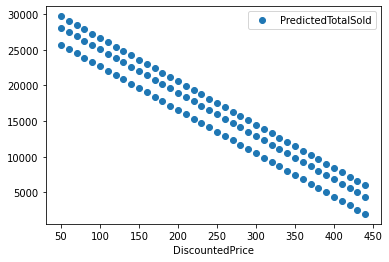

In [ ]:
scores.plot(x='DiscountedPrice', y='PredictedTotalSold', style='o')

Finally, predicted revenue with respect to discount price is obtained.

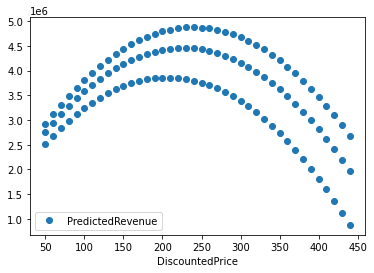

In [ ]:
scores.plot(x='DiscountedPrice', y='PredictedRevenue', style='o')

In [ ]:
scores.head()

,Year,Month,DiscountedPrice,AvgSalesPrice,TotalSold,Revenue,PredictedTotalSold,PredictedRevenue
0,2020.0,4.0,50.0,97.920340,15935.0,4.446380e+06,28132.961902,2.754789e+06
1,2020.0,4.0,60.0,106.901442,15935.0,4.446380e+06,27523.732253,2.942327e+06
2,2020.0,4.0,70.0,115.882544,15935.0,4.446380e+06,26914.502604,3.118921e+06
3,2020.0,4.0,80.0,124.863646,15935.0,4.446380e+06,26305.272955,3.284572e+06
4,2020.0,4.0,90.0,133.844748,15935.0,4.446380e+06,25696.043307,3.439280e+06


The top point of the curves shows the possible prices that are expected to generate the maximum revenue.

In [ ]:
comparison = scores[scores['PredictedRevenue'] == scores.groupby('Month')['PredictedRevenue'].transform(max)]

In [ ]:
comparison

,Year,Month,DiscountedPrice,AvgSalesPrice,TotalSold,Revenue,PredictedTotalSold,PredictedRevenue
18,2020.0,4.0,230.0,259.580177,15935.0,4.446380e+06,17166.828223,4.456168e+06
59,2020.0,6.0,240.0,268.561279,14924.0,4.733471e+06,18153.775383,4.875401e+06
96,2020.0,7.0,210.0,241.617973,6636.0,2.504602e+06,15970.144987,3.858674e+06


The difference of actual values and the estimated values of the model for the revenue-maximizing discounted prices in April, June and July are shown below.

In [ ]:
diff = comparison['PredictedRevenue'] - comparison['Revenue']
diff

18    9.788626e+03
59    1.419302e+05
96    1.354072e+06
dtype: float64